In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
import keras.preprocessing.image as kerasImage
import keras.backend as K
from tensorflow.python.ops import gen_nn_ops
import tensorflow as tf
import numpy as np
import copy as cp
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

Using TensorFlow backend.


In [2]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def gamma_correction(image,gamma=0.4,minamp=0,maxamp=None):
    gamImg = np.zeros_like(image)
    image -= minamp
    if maxamp is None:
        maxamp = np.abs(image).max()+K.epsilon()
    image /= maxamp
    posMask = (image > 0)
    negMask = (image < 0)
    gamImg[posMask] = np.power(image[posMask], gamma)
    gamImg[negMask] = -np.power(-image[negMask], gamma)
    gamImg = gamImg * maxamp + minamp
    return gamImg

def project_image(image,outputRange=(0,1),absMax=None,onlyPos=False):
    if absMax is None:
        absMax = np.max(np.abs(image),axis=tuple(range(1,len(image.shape))))
    absMax = np.asarray(absMax)
    mask = (absMax != 0)
    if mask.sum() > 0:
        image[mask] /= absMax[mask]
    if not onlyPos:
        image = (image+1)/2
    image = np.clip(image,0,1).astype('float32')
    projection = outputRange[0]+image*(outputRange[1]-outputRange[0])
    return projection

def reduce_channels(image,axis=-1,option='sum'):
    if option == 'sum':
        return image.sum(axis=axis)
    elif option == 'mean':
        return image.mean(axis=axis)
    elif option == 'max':
        posMax = image.max(axis=axis)
        negMax = -((-image).max(axis=axis))
        return np.select([posMax >= negMax, posMax < negMax], [posMax, negMax])
    else:
        assert False, 'This option is not supported'

def compute_heatmap(image,cmapType='bwr',reduceOption='sum',reduceAxis=-1):
    cmap = get_cmap(cmapType)
    shape = list(image.shape)
    reducedImg = reduce_channels(image, axis=reduceAxis, option=reduceOption)
    projImg = project_image(reducedImg)
    heatmap = cmap(projImg.flatten())[:,:3].T
    heatmap = heatmap.T
    shape[reduceAxis] = 3
    return heatmap.reshape(shape)

def visualize_heatmap(image,heatmap,savePath):
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(122)
    plt.title('LRP')
    plt.axis('off')
    plt.imshow(heatmap[0],interpolation='bilinear')
    fig.savefig(savePath)

In [3]:
# -- Z RULE -- #
class ZRule(object):
    
    def __init__(self,topLayer,subLayer):
        self.layer = topLayer
        self.type = self.layer.__class__.__name__
        self.act = subLayer.output
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
    
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.W = K.identity(weights[0])
        self.B = K.identity(weights[1])
        Z = K.dot(self.act,self.W)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = K.dot(S,K.transpose(self.W))
        return self.act*C
    
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        pooled = K.pool2d(self.act, 
                          pool_size = self.layer.pool_size, 
                          strides = self.layer.strides, 
                          padding = self.layer.padding,
                          pool_mode ='max')
        Z = K.maximum(pooled,0.)+K.epsilon()
        S = R/Z
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        C = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Z, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        return self.act*C
    
    def run_conv(self,R,ignoreBias):
        weights = self.layer.get_weights()
        self.W = K.identity(weights[0])
        self.B = K.identity(weights[1])
        Z = K.conv2d(self.act, 
                     kernel = self.W, 
                     strides = self.layer.strides,
                     padding = self.layer.padding)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        C = K.tf.nn.conv2d_backprop_input(K.shape(self.act),
                                          self.W,
                                          S, strdSize, padding = self.layer.padding.upper())
        return self.act*C

In [4]:
# -- Z+ RULE -- #
class ZPlus(object):
    
    def __init__(self,topLayer,subLayer):
        self.layer = topLayer
        self.type = self.layer.__class__.__name__
        self.act = subLayer.output
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
            
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.W = K.maximum(weights[0],0.)
        self.B = K.maximum(weights[1],0.)
        Z = K.dot(self.act,self.W)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = K.dot(S,K.transpose(self.W))
        return self.act*C
    
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        pooled = K.pool2d(self.act, 
                          pool_size = self.layer.pool_size, 
                          strides = self.layer.strides, 
                          padding = self.layer.padding,
                          pool_mode='max')
        Z = K.maximum(pooled,0.)+K.epsilon()
        S = R/Z
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        C = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Z, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        return self.act*C
    
    def run_conv(self,R,ignoreBias):
        weights = self.layer.get_weights()
        self.W = K.maximum(weights[0],0.)
        self.B = K.maximum(weights[1],0.)
        Z = K.conv2d(self.act, 
                     kernel = self.W, 
                     strides = self.layer.strides,
                     padding= self.layer.padding)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        C = K.tf.nn.conv2d_backprop_input(K.shape(self.act),
                                          self.W,
                                          S, strdSize, padding = self.layer.padding.upper())
        return self.act*C

In [3]:
# -- Zinter RULE -- # 
class ZInter(object):
    
    def __init__(self,topLayer,subLayer,L,H):
        self.layer = topLayer
        self.type = self.layer.__class__.__name__
        self.act = subLayer.output
        self.low = L
        self.high = H
    
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
        
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        lowAct = self.act*0+L; highAct = self.act*0+H
        self.W = K.identity(weights[0]); self.B = K.identity(weights[1])
        self.LW = K.minimum(weights[0],0.); 
        self.HW = K.maximum(weights[0],0.);
        Z = K.dot(self.act,self.W)-K.dot(lowAct,self.HW)-K.dot(highAct,self.LW)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        Cx = self.act*K.dot(S,K.transpose(self.W))
        Clow = K.dot(S,K.transpose(self.HW))*L; Chigh = K.dot(S,K.transpose(self.LW))*H
        return Cx-Clow-Chigh
    
    def run_flatten(self,R,ignoreBias=True):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)

    def run_pool(self,R):
        lowAct = self.act*0+L; highAct = self.act*0+H
        Zx = K.pool2d(self.act, 
                      pool_size = self.layer.pool_size, 
                      strides = self.layer.strides, 
                      padding = self.layer.padding,
                      pool_mode='max')
        Zhigh = K.pool2d(highAct, 
                      pool_size = self.layer.pool_size, 
                      strides = self.layer.strides, 
                      padding = self.layer.padding,
                      pool_mode='max')
        Zlow = K.pool2d(lowAct, 
                      pool_size = self.layer.pool_size, 
                      strides = self.layer.strides, 
                      padding = self.layer.padding,
                      pool_mode='max')
        Z = Zx-Zlow-Zhigh+K.epsilon()
        S = R/Z
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        Cx = self.act*gen_nn_ops.max_pool_grad_v2(self.act,
                                        Zx, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        Clow = self.low*gen_nn_ops.max_pool_grad_v2(lowAct,
                                        Zlow, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        Chigh = self.act*gen_nn_ops.max_pool_grad_v2(highAct,
                                        Zhigh, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        return Cx-Clow-Chigh
    
    def run_conv(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        lowAct = self.act*0+L; highAct = self.act*0+H
        self.W = K.identity(weights[0]); self.B = K.identity(weights[1])
        self.LW = K.minimum(weights[0],0.); 
        self.HW = K.maximum(weights[0],0.);
        Zx = K.conv2d(self.act,
                      kernel = self.W, 
                      strides = self.layer.strides,
                      padding= self.layer.padding)
        Zlow = K.conv2d(lowAct,
                        kernel = self.HW,
                        strides = self.layer.strides,
                        padding = self.layer.padding)
        Zhigh = K.conv2d(highAct,
                         kernel = self.LW,
                        strides = self.layer.strides,
                        padding = self.layer.padding)
        Z = Zx-Zlow-Zhigh+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        Cx = self.act*K.tf.nn.conv2d_backprop_input(K.shape(self.act),self.W,
                                          S, strdSize, padding = self.layer.padding.upper())
        Clow = L*K.tf.nn.conv2d_backprop_input(K.shape(self.act),self.HW,
                                          S, strdSize, padding = self.layer.padding.upper())
        Chigh = H*K.tf.nn.conv2d_backprop_input(K.shape(self.act),self.LW,
                                          S, strdSize, padding = self.layer.padding.upper())
        return Cx-Clow-Chigh

In [3]:
# -- Zab RULE -- #
class ZAlphaBeta(object):
    
    def __init__(self,topLayer,subLayer,alpha):
        self.alpha = alpha
        self.beta = alpha-1
        self.layer = topLayer
        self.type = self.layer.__class__.__name__
        self.act = subLayer.output
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
        
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.maxW = K.maximum(weights[0],0.); self.maxB = K.maximum(weights[1],0.)
        self.minW = K.minimum(weights[0],0.); self.minB = K.minimum(weights[1],0.)   
        Za = K.dot(self.act,self.maxW)+K.epsilon(); Zb = K.dot(self.act,self.minW)-K.epsilon()
        if not ignoreBias:
            Za += self.maxB; Zb += self.minB
        Sa = R/Za; Sb = R/Zb
        Ca = K.dot(Sa,K.transpose(self.maxW)); Cb = K.dot(Sb,K.transpose(self.minW))
        return self.act*(self.alpha*Ca+self.beta*Cb)
        
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        pooled = K.pool2d(self.act, 
                          pool_size = self.layer.pool_size, 
                          strides = self.layer.strides, 
                          padding = self.layer.padding,
                          pool_mode='max')
        Za = K.maximum(pooled,0.)+K.epsilon(); Zb = K.minimum(pooled,0.)-K.epsilon()
        Sa = R/Za; Sb = R/Zb
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        Ca = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Za, Sa, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        Cb = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Zb, Sb, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        return self.act*(self.alpha*Ca+self.beta*Cb)
    
    def run_conv(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.maxW = K.maximum(weights[0],0.); self.maxB = K.maximum(weights[1],0.)
        self.minW = K.minimum(weights[0],0.); self.minB = K.minimum(weights[1],0.)
        Za = K.conv2d(self.act, 
                     kernel = self.maxW, 
                     strides = self.layer.strides,
                     padding = self.layer.padding)+K.epsilon()
        Zb = K.conv2d(self.act,
                     kernel = self.minW,
                     strides = self.layer.strides,
                     padding = self.layer.padding)-K.epsilon()
        if not ignoreBias:
            Za += self.maxB; Zb += self.minB
        Sa = R/Za; Sb = R/Zb
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        Ca = K.tf.nn.conv2d_backprop_input(K.shape(self.act),
                                          self.maxW,
                                          Sa, strdSize, padding = self.layer.padding.upper())
        Cb = K.tf.nn.conv2d_backprop_input(K.shape(self.act),
                                          self.minW,
                                          Sb, strdSize, padding = self.layer.padding.upper())
        return self.act*(self.alpha*Ca+self.beta*Cb)

Select image:  test_5
Select rule: (0):Z (1):Z+ (2):ZI (3):Zab 3


Instructions for updating:
Colocations handled automatically by placer.
---------------------------
('predictions', 'Dense')
---------------------------
('fc2', 'Dense')
---------------------------
('fc1', 'Dense')
---------------------------
('flatten', 'Flatten')
---------------------------
('block5_pool', 'MaxPooling2D')
---------------------------
('block5_conv3', 'Conv2D')
---------------------------
('block5_conv2', 'Conv2D')
---------------------------
('block5_conv1', 'Conv2D')
---------------------------
('block4_pool', 'MaxPooling2D')
---------------------------
('block4_conv3', 'Conv2D')
---------------------------
('block4_conv2', 'Conv2D')
---------------------------
('block4_conv1', 'Conv2D')
---------------------------
('block3_pool', 'MaxPooling2D')
---------------------------
('block3_conv3', 'Conv2D')
---------------------------
('block3_conv2', 'Conv2D')
---------------------------
('block3_conv1', 'Conv2D')
---------------------------
('block2_pool', 'MaxPooling2D')

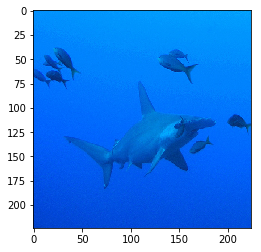

In [4]:
# -- MAIN -- #
if not os.path.isdir('./Results/LRP'):
    os.mkdir('./Results/LRP')
# -- DEFINE VARIABLES -- #
alpha = 1
H = 1; L = -H
# -- PREPARE DATA -- #
imgSel = input('Select image: ')
rulSel = int(input('Select rule: (0):Z (1):Z+ (2):ZI (3):Zab'))
imgPath = './Data/images/'+imgSel+'.jpg'
rawData = load_image(imgPath,preprocess=False)
data = load_image(imgPath)
plt.imshow(rawData)
# -- DEFINE MODEL -- #
model = VGG16(weights='imagenet',include_top=True)
numLayers = len(model.layers)
# -- COMPUTE LRP -- #
rules = []
R = 0
if rulSel == 0:
    for k in range(numLayers-2,-1,-1):
        rules.append(ZRule(model.layers[k+1],model.layers[k]))
elif rulSel == 1:
    for k in range(numLayers-2,-1,-1):
        rules.append(ZPlus(model.layers[k+1],model.layers[k]))
elif rulSel == 2:
    for k in range(numLayers-2,-1,-1):
        rules.append(ZInter(model.layers[k+1],model.layers[k],L,H))
elif rulSel == 3:
    for k in range(numLayers-2,-1,-1):
        rules.append(ZAlphaBeta(model.layers[k+1],model.layers[k],alpha))
else:
    assert False, 'This rule is not supported'
R = model.output
print('---------------------------')
for k in range(len(rules)):
    R = rules[k].run(R,ignoreBias=False)
    print((rules[k].layer.name,rules[k].type))
    print('---------------------------')
lrpRunner = K.function([model.input],[R])
model.predict(data.copy())
lrp = lrpRunner([data.copy()])[0]
print('DONE!')

Model prediction:
	hammerhead     	(4)	with probability 0.888
	great_white_shark	(2)	with probability 0.087
	tiger_shark    	(3)	with probability 0.024
	electric_ray   	(5)	with probability 0.000
	dugong         	(149)	with probability 0.000


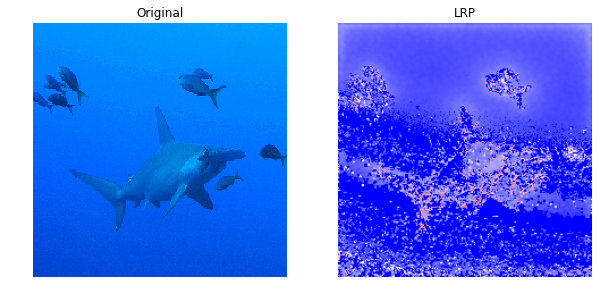

In [5]:
# -- COMPUTE HEATMAP -- #
cmap = 'bwr'
redOpt = 'sum'
prediction = model.predict(data.copy())
top = decode_predictions(prediction, top=5)[0]
classes = np.argsort(prediction[0])[-5:][::-1]
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
gam = gamma_correction(lrp.copy(),gamma=0.15)
heatmap = compute_heatmap(gam,cmapType=cmap,reduceOption=redOpt)
visualize_heatmap(rawData,heatmap,'./Results/LRP/'+str(rulSel)+'_'+imgSel+'13.png')